In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib

In [5]:
data = pd.read_csv('/workspaces/Sales-Forecasting-For-Supply-Chain-Walmart/walmart.csv')

In [6]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   str    
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), str(1)
memory usage: 402.3 KB


In [8]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [9]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [10]:
data.shape

(6435, 8)

In [11]:
data.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='str')

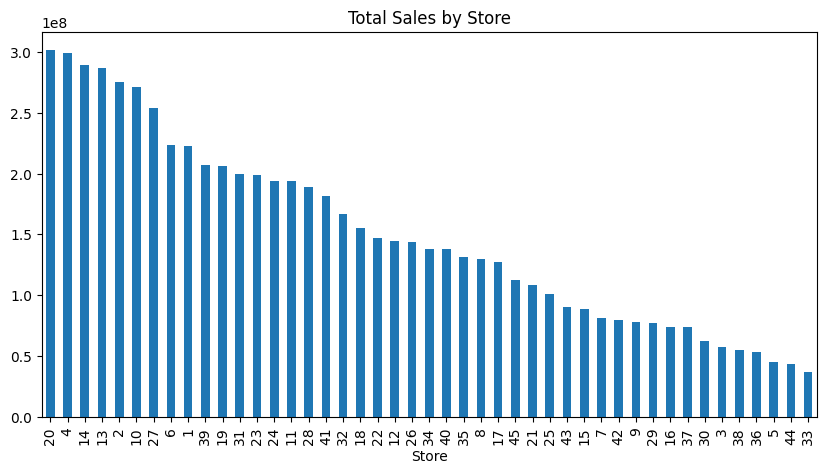

In [12]:
store_sales = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
store_sales.plot(kind='bar', figsize=(10,5))
plt.title('Total Sales by Store')
plt.show()

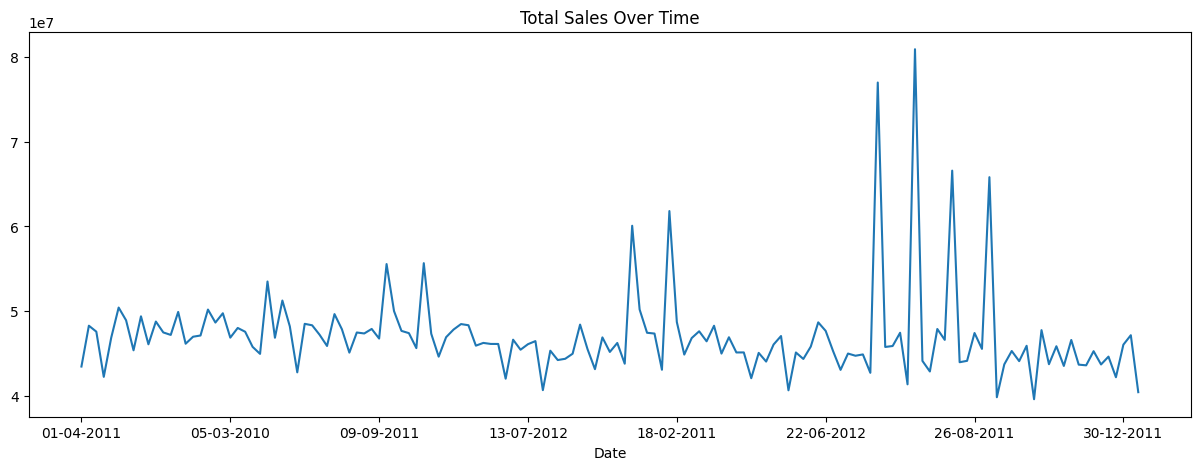

In [13]:
data.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(15,5))
plt.title('Total Sales Over Time')
plt.show()

In [14]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [15]:
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Lag feature (sales last week)
data['Lag_1'] = data.groupby(['Store'])['Weekly_Sales'].shift(1)

# Rolling mean (last 4 weeks)
data['Rolling_Mean_4'] = data.groupby(['Store'])['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).mean())

In [16]:
# Sort by date
data = data.sort_values(by='Date')

# Train: 2010-2012, Test: 2012-2013 (example)
train = data[data['Date'] < '2012-01-01']
test = data[data['Date'] >= '2012-01-01']

features = ['Store','Week','Month','Year','Lag_1','Rolling_Mean_4']
target = 'Weekly_Sales'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

#Implementing Linear Regression

In [17]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]

model = LinearRegression()
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [18]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 120992.3039112964


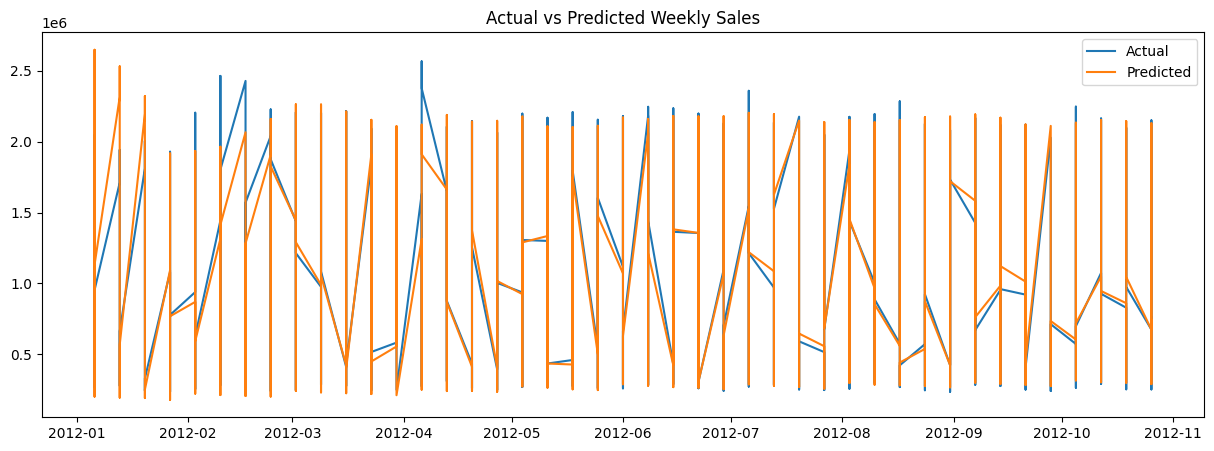

In [19]:
plt.figure(figsize=(15,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Weekly Sales')
plt.show()

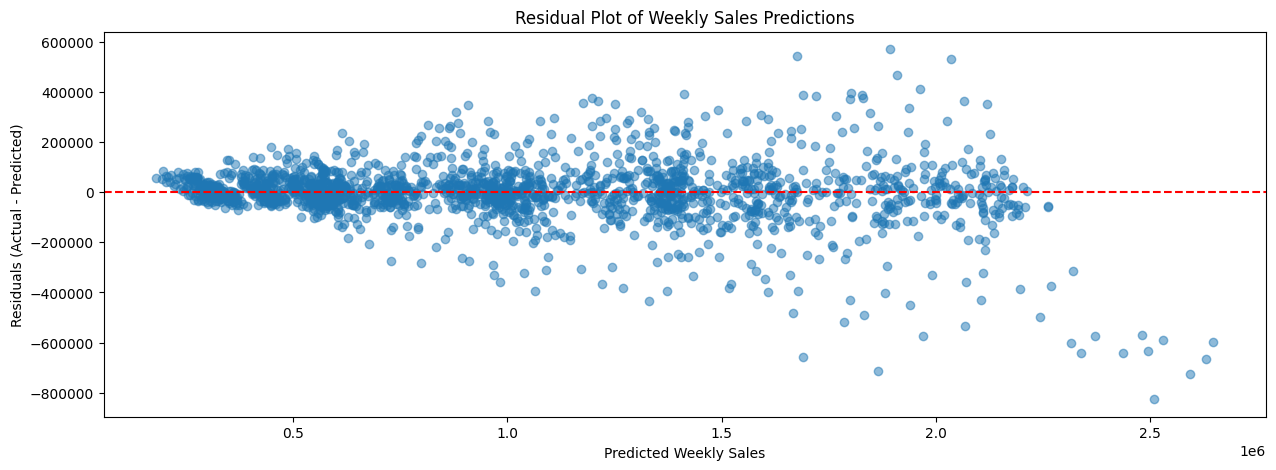

In [20]:
residuals = y_test - y_pred

plt.figure(figsize=(15, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot of Weekly Sales Predictions')
plt.show()

### Implementing Random Forest Regression

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # You can tune n_estimators

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
print(f'Random Forest RMSE: {rf_rmse}')

Random Forest RMSE: 76826.96071567692


### Visualizing Random Forest Predictions

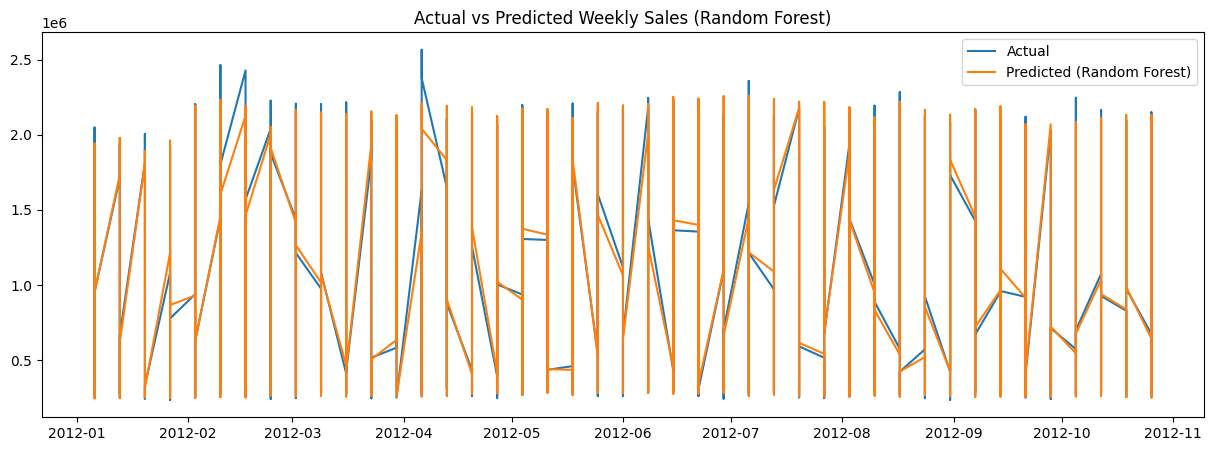

In [22]:
plt.figure(figsize=(15,5))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], rf_y_pred, label='Predicted (Random Forest)')
plt.legend()
plt.title('Actual vs Predicted Weekly Sales (Random Forest)')
plt.show()

### Analyzing Random Forest Residuals

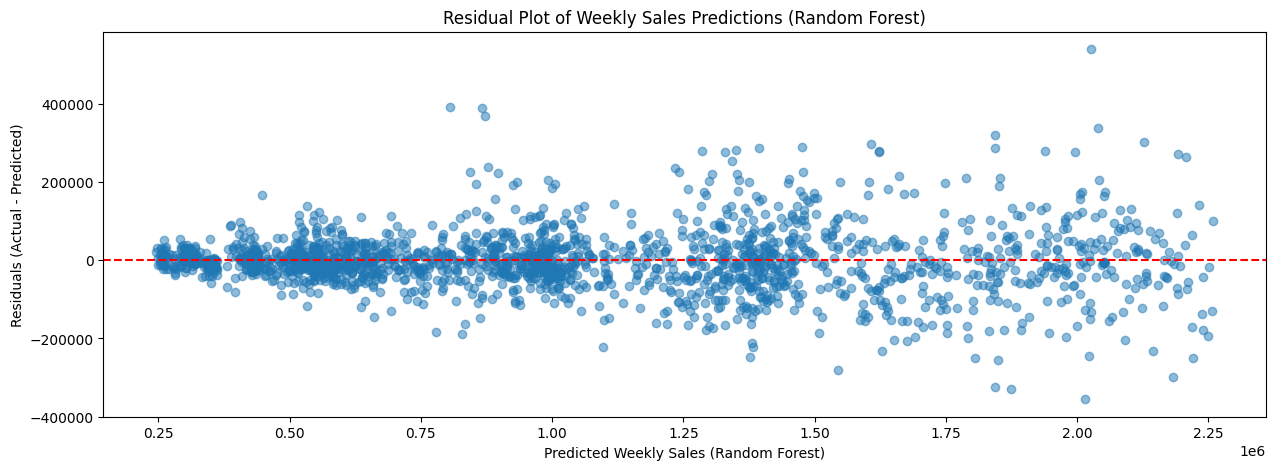

In [23]:
rf_residuals = y_test - rf_y_pred

plt.figure(figsize=(15, 5))
plt.scatter(rf_y_pred, rf_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weekly Sales (Random Forest)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot of Weekly Sales Predictions (Random Forest)')
plt.show()

Let's analyze the residuals to understand the model's performance better. Residuals are the differences between the actual and predicted values.

In [24]:
import joblib

joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

### Comparing Model Accuracy (RMSE)

In [25]:
print(f'Linear Regression RMSE: {rmse}')
print(f'Random Forest RMSE: {rf_rmse}')

if rf_rmse < rmse:
    print(f'The Random Forest model is more accurate, with an RMSE {rmse - rf_rmse:.2f} lower than the Linear Regression model.')
elif rmse < rf_rmse:
    print(f'The Linear Regression model is more accurate, with an RMSE {rf_rmse - rmse:.2f} lower than the Random Forest model.')
else:
    print('Both models have similar accuracy.')

Linear Regression RMSE: 120992.3039112964
Random Forest RMSE: 76826.96071567692
The Random Forest model is more accurate, with an RMSE 44165.34 lower than the Linear Regression model.


As you can see, the Random Forest model achieved a significantly lower RMSE, indicating better predictive accuracy on this dataset.